# Variational Auto Encoder
This notebook demonstrates the training of a Variational Autoencoder (VAE) to learn transformations from input climate data to corresponding forced responses.

In [1]:
# Import necessary libraries
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import random
import warnings


from torch.utils.data import DataLoader

# Add utility paths
sys.path.append(os.path.join(os.getcwd(), 'utils'))

# Import utility functions
from utils.data_loading import *
from utils.data_processing import *
from utils.vae import *
from utils.animation import *
from utils.metrics import *
from utils.pipeline import *

# Enable autoreload
%reload_ext autoreload
%autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define data path
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data')
print(f"Data path: {data_path}")

Data path: /Users/lharriso/Documents/GitHub/gm4cs-l/data


In [2]:
# Use MPS / Cuda or CPU if none of the options are available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
random.seed(42)

Using device: mps


In [3]:
# Load the data
filename = os.path.join(data_path, 'ssp585_time_series.pkl')
data, nan_mask = preprocess_data(data_path, filename)

Loading data from /Users/lharriso/Documents/GitHub/gm4cs-l/data/ssp585_time_series.pkl
Data loaded successfully.
Filtering data...


100%|██████████| 72/72 [00:00<00:00, 33851.57it/s]


Data filtered. Kept 34 models
Creating NaN mask...


100%|██████████| 34/34 [00:02<00:00, 14.45it/s]


NaN mask created.
Masking out NaN values...


100%|██████████| 34/34 [00:01<00:00, 28.58it/s]


NaN values masked out.
Reshaping data...


100%|██████████| 34/34 [00:04<00:00,  8.48it/s]


Data reshaped.
Adding the forced response to the data...


100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Forced response added.
Removing NaN values from the grid...


100%|██████████| 34/34 [00:01<00:00, 22.88it/s]


NaN values removed.


In [4]:
# Randomly select and keep the data corresponding to n models
n = 5
model_keys = random.sample(data.keys(), n)
data = {key: value for key,value in data.items() if key in model_keys}

/var/folders/9v/q6t68ds12f9c4dgn9gnwzrmr0000gn/T/ipykernel_79292/3740862327.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  model_keys = random.sample(data.keys(), n)


In [5]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data.keys()))
train_models = [model for model in data.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data[model] for model in train_models}
test_data = {test_model: data[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['EC-Earth3', 'E3SM-2-0', 'GISS-E2-1-G', 'ACCESS-ESM1-5']
Testing model: GISS-E2-2-G


In [6]:
center = True
normalized_train_data, normalized_test_data, _, _ = normalize_data(train_data, test_data, center=center)


Normalizing data...


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]

Data normalization completed.


Flattened the data


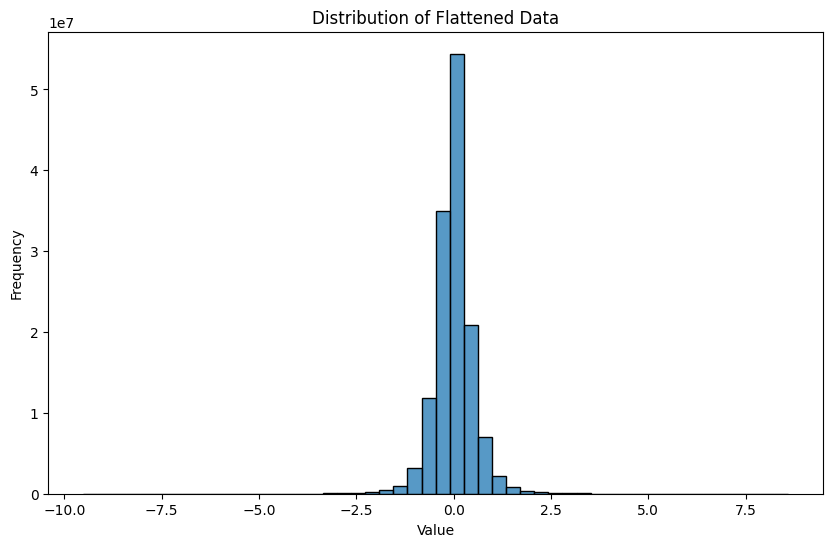

In [7]:
# Print the distribution of the data
# Flatten the data for analysis
flattened_data = np.concatenate([np.ravel(array) for model in normalized_train_data.values() for array in model.values()])
print("Flattened the data")
# Plot the distribution of the data
plt.figure(figsize=(10, 6))
sns.histplot(flattened_data, bins=50, kde=False)
plt.title('Distribution of Flattened Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

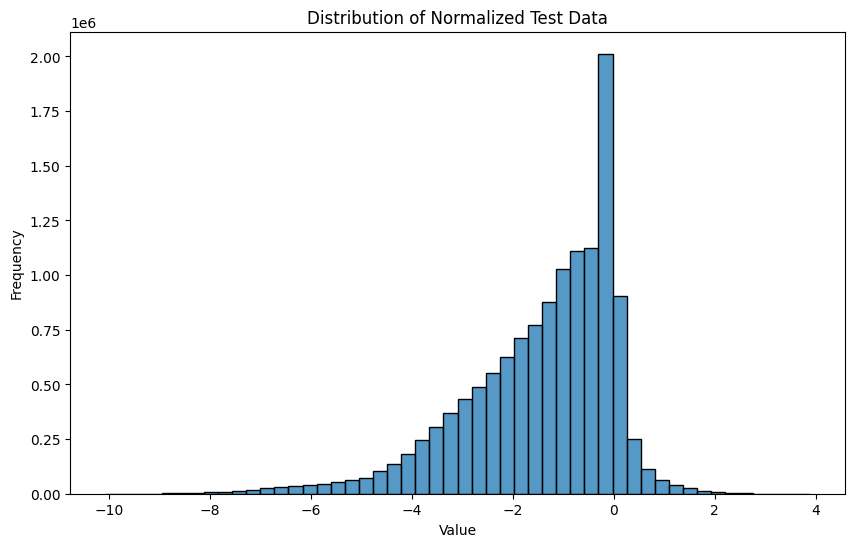

In [8]:
# Flatten the normalized_test_data for analysis
flattened_test_data = np.concatenate([np.ravel(array) for model in normalized_test_data.values() for array in model.values()])

# Plot the distribution of the flattened normalized_test_data
plt.figure(figsize=(10, 6))
sns.histplot(flattened_test_data, bins=50, kde=False)
plt.title('Distribution of Normalized Test Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Create dataset
train_dataset = ClimateDataset(normalized_train_data)
test_dataset = ClimateDataset(normalized_test_data)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Print dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

Creating datasets...


Processing models: 100%|██████████| 4/4 [00:00<00:00, 105517.08it/s]
/Users/lharriso/Documents/GitHub/gm4cs-l/utils/vae.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.inputs = torch.tensor(self.inputs, dtype=torch.float32)


Creating datasets...


Processing models: 100%|██████████| 1/1 [00:00<00:00, 31300.78it/s]


Training dataset size: 124
Testing dataset size: 11


In [11]:
# Initialize the VAE model
input_dim = train_dataset.inputs.shape[1] * train_dataset.inputs.shape[2]  # Flattened input dimensions
latent_dim = 50  # Reduced from 100
hidden_dim = 25  # Reduced from 50
mu_var_dim = 5  # Reduced from 10
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
vae_model = VAE(input_dim=input_dim, hidden_dim = hidden_dim, latent_dim=latent_dim, device=device, mu_var_dim=mu_var_dim).to(device)

# Apply weight initialization
vae_model.apply(initialize_weights)

# Define optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Lower learning rate and add weight decay

# Train the VAE
train_vae(vae_model, train_loader, optimizer, epochs=10, device=device)

Using device: mps


 10%|█         | 1/10 [00:00<00:07,  1.27it/s]

Epoch 1, Average Loss: 743784.8608870967


 20%|██        | 2/10 [00:01<00:06,  1.26it/s]

Epoch 2, Average Loss: 739590.8084677419


 30%|███       | 3/10 [00:02<00:05,  1.26it/s]

Epoch 3, Average Loss: 734791.4556451613


 40%|████      | 4/10 [00:03<00:04,  1.26it/s]

Epoch 4, Average Loss: 730079.0060483871


 50%|█████     | 5/10 [00:03<00:03,  1.25it/s]

Epoch 5, Average Loss: 725934.0504032258


 60%|██████    | 6/10 [00:04<00:03,  1.26it/s]

Epoch 6, Average Loss: 722077.4596774194


 70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

Epoch 7, Average Loss: 718421.6935483871


 80%|████████  | 8/10 [00:06<00:01,  1.26it/s]

Epoch 8, Average Loss: 715063.5141129033


 90%|█████████ | 9/10 [00:07<00:00,  1.25it/s]

Epoch 9, Average Loss: 711203.7822580645


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

Epoch 10, Average Loss: 708494.6653225806
